In [25]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV

from sklearn.metrics import accuracy_score, log_loss

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import cv2

%matplotlib inline

In [ ]:
# Đọc file CSV từ URL
url = 'https://raw.githubusercontent.com/NgoNhutTan/data/refs/heads/main/Bitcoin%20Historical%20Data.csv'
df = pd.read_csv(url)
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Aug 02, 2020","11,105.8","11,802.6","12,061.1","10,730.7",698.62K,-5.91%
1,"Aug 01, 2020","11,803.1","11,333.2","11,847.7","11,226.1",611.47K,4.14%
2,"Jul 31, 2020","11,333.4","11,096.5","11,434.8","10,964.6",530.95K,2.14%
3,"Jul 30, 2020","11,096.2","11,105.8","11,164.4","10,861.6",501.14K,-0.09%
4,"Jul 29, 2020","11,105.9","10,908.4","11,336.5","10,771.8",576.83K,1.81%


In [27]:
from datetime import datetime

def convert_timestamp(date_str):
    """Chuyển đổi định dạng ngày từ 'MMM DD, YYYY' sang datetime."""
    return datetime.strptime(date_str, "%b %d, %Y")

# Áp dụng chuyển đổi cho cột 'Date'
df["Date"] = df["Date"].apply(convert_timestamp)

# Hiển thị lại 5 dòng đầu tiên để kiểm tra
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2020-08-02,"11,105.8","11,802.6","12,061.1","10,730.7",698.62K,-5.91%
1,2020-08-01,"11,803.1","11,333.2","11,847.7","11,226.1",611.47K,4.14%
2,2020-07-31,"11,333.4","11,096.5","11,434.8","10,964.6",530.95K,2.14%
3,2020-07-30,"11,096.2","11,105.8","11,164.4","10,861.6",501.14K,-0.09%
4,2020-07-29,"11,105.9","10,908.4","11,336.5","10,771.8",576.83K,1.81%


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3669 entries, 0 to 3668
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3669 non-null   datetime64[ns]
 1   Price     3669 non-null   object        
 2   Open      3669 non-null   object        
 3   High      3669 non-null   object        
 4   Low       3669 non-null   object        
 5   Vol.      3669 non-null   object        
 6   Change %  3669 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 200.8+ KB


In [29]:
# Thay thế giá trị NaN trong cột Volume bằng 0
df["Vol."].fillna(0, inplace=True)

# Điền dữ liệu OHLC bằng phương pháp forward fill
ohlc_columns = ["Open", "High", "Low", "Price"]
df[ohlc_columns] = df[ohlc_columns].ffill()

# Hiển thị 5 dòng đầu tiên sau khi xử lý
df.head()


<ipython-input-29-602f1a364d83>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,Date,Price,Open,High,Low,Vol.,Change %
0,2020-08-02,"11,105.8","11,802.6","12,061.1","10,730.7",698.62K,-5.91%
1,2020-08-01,"11,803.1","11,333.2","11,847.7","11,226.1",611.47K,4.14%
2,2020-07-31,"11,333.4","11,096.5","11,434.8","10,964.6",530.95K,2.14%
3,2020-07-30,"11,096.2","11,105.8","11,164.4","10,861.6",501.14K,-0.09%
4,2020-07-29,"11,105.9","10,908.4","11,336.5","10,771.8",576.83K,1.81%


In [30]:
import pytz

# Chuyển đổi cột Date sang Unix timestamp
df["Timestamp"] = df["Date"].apply(lambda x: x.timestamp())

# Định nghĩa hàm chuyển đổi timestamp về 00:00:00 UTC
def dateparse_midnight(time_in_secs):
    dt = pytz.utc.localize(datetime.fromtimestamp(float(time_in_secs)))
    return dt.replace(hour=0, minute=0, second=0, microsecond=0)  # Đặt về 00:00:00

# Áp dụng hàm chuyển đổi
df["Date"] = df["Timestamp"].apply(dateparse_midnight)

# Xóa cột Timestamp sau khi chuyển đổi
df.drop(columns=["Timestamp"], inplace=True)

# Hiển thị 5 dòng đầu tiên để kiểm tra
df.head()


,Date,Price,Open,High,Low,Vol.,Change %
0,2020-08-02 00:00:00+00:00,"11,105.8","11,802.6","12,061.1","10,730.7",698.62K,-5.91%
1,2020-08-01 00:00:00+00:00,"11,803.1","11,333.2","11,847.7","11,226.1",611.47K,4.14%
2,2020-07-31 00:00:00+00:00,"11,333.4","11,096.5","11,434.8","10,964.6",530.95K,2.14%
3,2020-07-30 00:00:00+00:00,"11,096.2","11,105.8","11,164.4","10,861.6",501.14K,-0.09%
4,2020-07-29 00:00:00+00:00,"11,105.9","10,908.4","11,336.5","10,771.8",576.83K,1.81%


In [31]:
# Lọc ra các ngày là thứ Hai (Monday)
mondays = df[df['Date'].dt.dayofweek == 0][['Date']]

# Hiển thị kết quả
mondays

,Date
6,2020-07-27 00:00:00+00:00
13,2020-07-20 00:00:00+00:00
20,2020-07-13 00:00:00+00:00
27,2020-07-06 00:00:00+00:00
34,2020-06-29 00:00:00+00:00
...,...
3639,2010-08-16 00:00:00+00:00
3646,2010-08-09 00:00:00+00:00
3653,2010-08-02 00:00:00+00:00
3660,2010-07-26 00:00:00+00:00


In [32]:
# Xác định phạm vi ngày hợp lệ
start_time = datetime(2014, 12, 1, tzinfo=pytz.UTC)  # Thay đổi theo yêu cầu
end_time = datetime(2020, 12, 31, tzinfo=pytz.UTC)  # Thay đổi theo yêu cầu

# Lọc các hàng trong khoảng thời gian hợp lệ
df_filtered = df[(df["Date"] >= start_time) & (df["Date"] <= end_time)]

# Lọc ra các ngày là thứ Hai (Monday)
mondays = df_filtered[df_filtered["Date"].dt.dayofweek == 0]

# Tìm hàng đầu tiên vào đúng 00:00 sáng thứ Hai
first_monday = mondays[mondays["Date"].dt.time == datetime.min.time()]

# Hiển thị hàng đầu tiên nếu có
first_monday.head()


,Date,Price,Open,High,Low,Vol.,Change %
6,2020-07-27 00:00:00+00:00,"11,022.8","9,932.7","11,367.0","9,894.6",908.99K,10.98%
13,2020-07-20 00:00:00+00:00,"9,162.4","9,208.1","9,218.4","9,139.9",312.98K,-0.50%
20,2020-07-13 00:00:00+00:00,"9,243.6","9,300.5","9,329.6","9,207.6",456.87K,-0.62%
27,2020-07-06 00:00:00+00:00,"9,339.0","9,080.4","9,363.0","9,063.2",510.27K,2.84%
34,2020-06-29 00:00:00+00:00,"9,185.4","9,122.8","9,229.1","9,033.6",401.12K,0.67%


In [33]:
import plotly.graph_objects as go
from plotly.offline import iplot

# Assume df_filtered is the DataFrame you want to plot
# If not, replace it with the correct DataFrame name
df_plot = df_filtered

# Chỉ sử dụng Open và Price để vẽ biểu đồ
trace1 = go.Scatter(
    x=df_plot["Date"],
    y=df_plot["Open"],
    mode="lines",
    name="Open"
)

trace2 = go.Scatter(
    x=df_plot["Date"],
    y=df_plot["Price"],  # Giá trung bình
    mode="lines",
    name="Weighted Avg"
)

# Cấu hình giao diện
layout = dict(
    title="Historical Bitcoin Prices (2010-2020) with the Slider",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=12, label="1y", step="month", stepmode="backward"),
                dict(count=36, label="3y", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

# Tổng hợp dữ liệu và hiển thị
data = [trace1, trace2]
fig = dict(data=data, layout=layout)
iplot(fig, filename="Time Series with Rangeslider")

In [34]:
def convert_volume(value):
    if isinstance(value, str):
        value = value.strip()  # Xóa khoảng trắng
        if value == '-' or value == '':  # Nếu là dấu '-' hoặc rỗng, trả về NaN
            return np.nan
        elif 'K' in value:
            return float(value.replace('K', '')) * 1e3
        elif 'M' in value:
            return float(value.replace('M', '')) * 1e6
        elif 'B' in value:
            return float(value.replace('B', '')) * 1e9
        else:
            return float(value)  # Trường hợp số bình thường
    return np.nan  # Nếu giá trị không phải chuỗi, trả về NaN

# Áp dụng hàm chuyển đổi
df["Volume"] = df["Vol."].apply(convert_volume)

In [35]:
df[["Vol.", "Volume"]].head()


,Vol.,Volume
0,698.62K,698620.0
1,611.47K,611470.0
2,530.95K,530950.0
3,501.14K,501140.0
4,576.83K,576830.0


In [36]:
import plotly.graph_objects as go

# Vẽ biểu đồ Volume theo thời gian
trace = go.Scatter(
    x=df["Date"],
    y=df["Volume"],
    mode="lines",
    name="Market Volume",
    line=dict(color='blue')
)

layout = dict(
    title="Historical Bitcoin Market Volume (2010-2020)",
    xaxis=dict(
        title="Date",
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=12, label="1y", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(title="Volume (BTC)")
)

# Tạo figure và hiển thị
fig = go.Figure(data=[trace], layout=layout)
fig.show()


In [37]:
import plotly.graph_objects as go

# Tạo traces cho Price và Volume
trace1 = go.Scatter(
    x=df["Date"],
    y=df["Price"],  # Giá Bitcoin
    mode="lines",
    name="Bitcoin Price (USD)",
    yaxis="y1"  # Trục y đầu tiên
)

trace2 = go.Bar(
    x=df["Date"],
    y=df["Volume"],  # Volume giao dịch
    name="Trading Volume",
    yaxis="y2",  # Trục y thứ hai
    opacity=0.6
)

# Layout
layout = go.Layout(
    title="Bitcoin Volume vs Price",
    xaxis=dict(title="Date"),
    yaxis=dict(
        title="Bitcoin Price (USD)",
        side="left",
        showgrid=False
    ),
    yaxis2=dict(
        title="Trading Volume",
        overlaying="y",
        side="right",
        showgrid=False
    ),
    legend=dict(x=0, y=1),
)

# Kết hợp dữ liệu và layout
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Hiển thị biểu đồ
fig.show()


In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Chuyển đổi cột 'Date' thành datetime và đặt làm index
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Loại bỏ dấu phẩy trong cột 'Price' và chuyển sang float
df["Price"] = df["Price"].str.replace(',', '').astype(float)

# Chia dữ liệu train/test theo ngày 25-Jun-2018
split_date = "2018-06-25"
data_train = df.loc[df.index <= split_date].copy()
data_test = df.loc[df.index > split_date].copy()

# Chuẩn hóa dữ liệu với MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_set = sc.fit_transform(data_train["Price"].values.reshape(-1, 1))

# Chuẩn bị X_train và y_train
X_train = training_set[:-1]  # Tất cả trừ phần tử cuối cùng
y_train = training_set[1:]   # Tất cả trừ phần tử đầu tiên

# Định dạng lại X_train thành (samples, timesteps, features)
X_train = np.reshape(X_train, (len(X_train), 1, 1))

print(f"✅ X_train shape: {X_train.shape}")
print(f"✅ y_train shape: {y_train.shape}")


✅ X_train shape: (2899, 1, 1)
✅ y_train shape: (2899, 1)


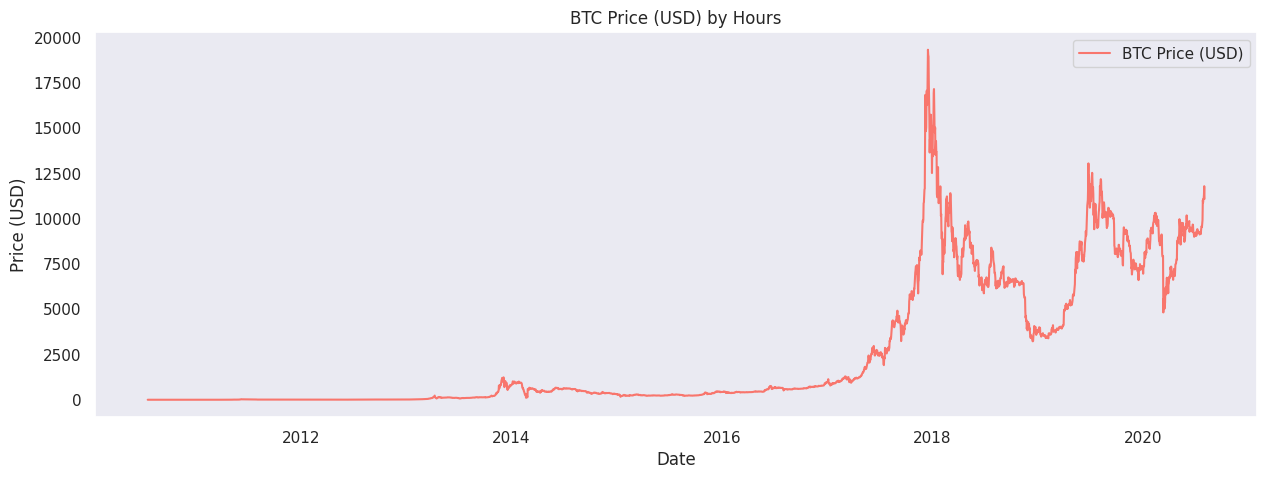

In [39]:
import matplotlib.pyplot as plt

# Định nghĩa bảng màu
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38",
             "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

# Vẽ biểu đồ BTC Price theo giờ
plt.figure(figsize=(15, 5))
plt.plot(df.index, df["Price"], linestyle='-', color=color_pal[0], label="BTC Price (USD)")

# Tùy chỉnh biểu đồ
plt.title("BTC Price (USD) by Hours")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()

# Hiển thị biểu đồ
plt.show()


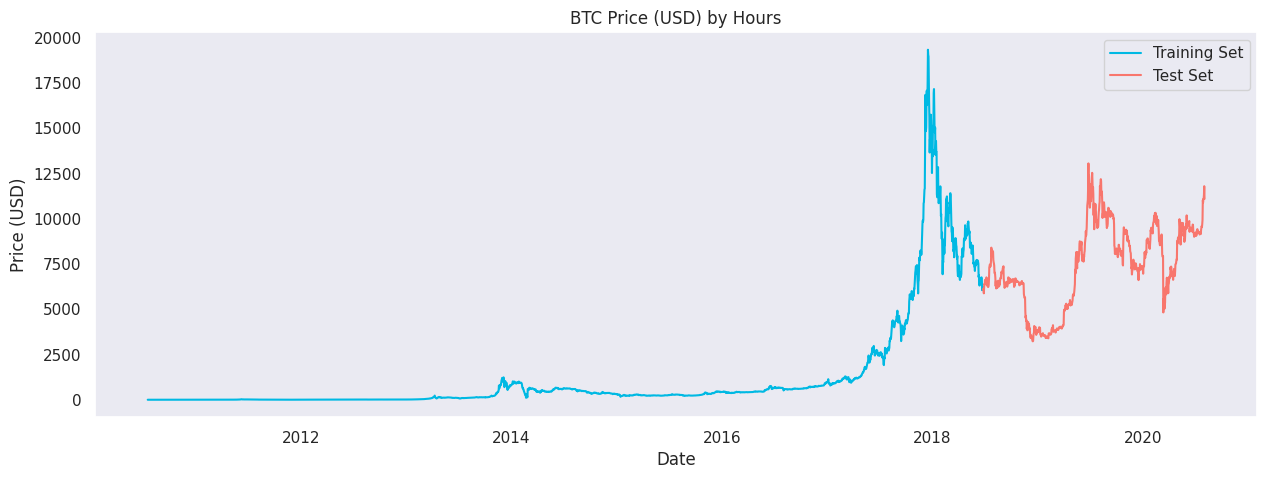

In [40]:
import matplotlib.pyplot as plt

# Đổi tên cột giá và hợp nhất dữ liệu với hậu tố tránh trùng lặp
df_plot = data_test.rename(columns={'Price': 'Test Set'}).join(
    data_train.rename(columns={'Price': 'Training Set'}),
    how='outer',
    lsuffix="_test",
    rsuffix="_train"
)

# Vẽ biểu đồ
plt.figure(figsize=(15, 5))
plt.plot(df_plot.index, df_plot["Training Set"], linestyle='-', label="Training Set", color="#00B9E3")
plt.plot(df_plot.index, df_plot["Test Set"], linestyle='-', label="Test Set", color="#F8766D")

# Tùy chỉnh biểu đồ
plt.title("BTC Price (USD) by Hours")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()

# Hiển thị biểu đồ
plt.show()


In [41]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



58/58 - 2s - 36ms/step - loss: 0.1118
Epoch 2/100
58/58 - 0s - 5ms/step - loss: 0.0504
Epoch 3/100
58/58 - 0s - 5ms/step - loss: 0.0462
Epoch 4/100
58/58 - 0s - 5ms/step - loss: 0.0401
Epoch 5/100
58/58 - 0s - 6ms/step - loss: 0.0359
Epoch 6/100
58/58 - 0s - 5ms/step - loss: 0.0334
Epoch 7/100
58/58 - 0s - 5ms/step - loss: 0.0297
Epoch 8/100
58/58 - 0s - 4ms/step - loss: 0.0286
Epoch 9/100
58/58 - 0s - 5ms/step - loss: 0.0261
Epoch 10/100
58/58 - 0s - 5ms/step - loss: 0.0240
Epoch 11/100
58/58 - 0s - 5ms/step - loss: 0.0206
Epoch 12/100
58/58 - 0s - 4ms/step - loss: 0.0195
Epoch 13/100
58/58 - 0s - 5ms/step - loss: 0.0186
Epoch 14/100
58/58 - 0s - 5ms/step - loss: 0.0172
Epoch 15/100
58/58 - 0s - 5ms/step - loss: 0.0155
Epoch 16/100
58/58 - 0s - 5ms/step - loss: 0.0146
Epoch 17/100
58/58 - 0s - 5ms/step - loss: 0.0137
Epoch 18/100
58/58 - 0s - 5ms/step - loss: 0.0121
Epoch 19/100
58/58 - 0s - 5ms/step - loss: 0.0112
Epoch 20/100
58/58 - 0s - 8ms/step - loss: 0.0107
Epoch 21/100
58/58 -

In [42]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 200,069 (781.52 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 133,380 (521.02 KB)

Số dòng sau khi xử lý: 769
Số lượng mẫu ban đầu: 769
Các cột trong data_test: Index(['Weighted_Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Volume',
       'Weighted_Price_Prediction'],
      dtype='object')
Kích thước test_set trước reshape: (769, 1)
Kích thước test_set sau reshape: (769, 1)
Kích thước inputs: (769, 1, 1)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Kích thước predicted_BTC_price: (769, 1)
Thêm cột dự đoán thành công!
Các cột hiện tại trong data_all: Index(['Weighted_Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Volume',
       'Weighted_Price_Prediction', 'Price'],
      dtype='object')
Cột 'Date' không tồn tại trong data_all! Kiểm tra lại nguồn dữ liệu.
Các cột sau khi reset_index: Index(['Date', 'Weighted_Price', 'Open', 'High', 'Low', 'Vol.', 'Change %',
       'Volume', 'Weighted_Price_Prediction', 'Price'],
      dtype='object')


<Axes: >

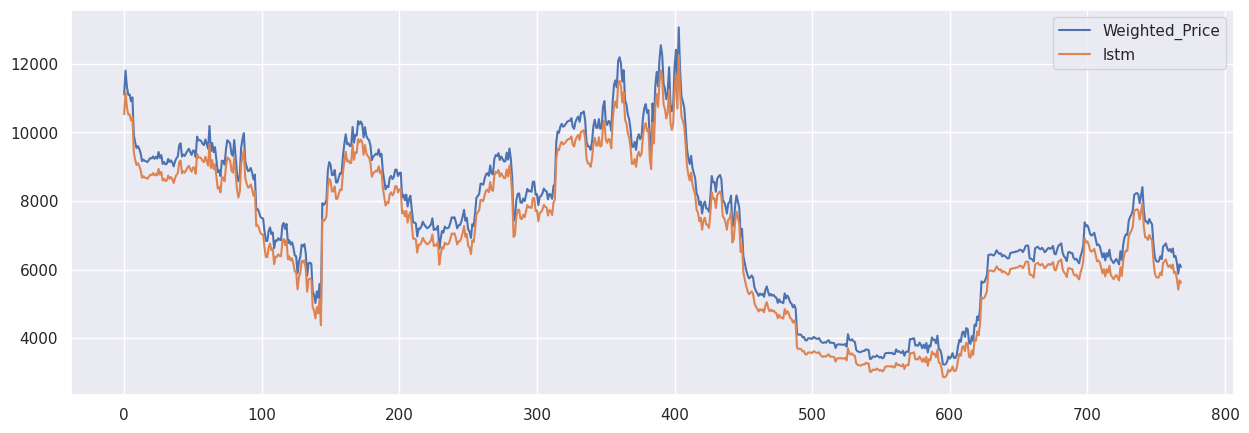

In [57]:
import numpy as np
import pandas as pd
import re

# Hàm chuyển đổi giá trị chứa 'K', 'M' hoặc '%'
def convert_to_float(value):
    if isinstance(value, str):
        value = value.replace(',', '').replace('%', '')  # Xóa dấu phẩy và dấu %
        if 'K' in value:
            return float(value.replace('K', '')) * 1000
        elif 'M' in value:
            return float(value.replace('M', '')) * 1000000
        elif '%' in value:
            return float(value.replace('%', '')) / 100  # Chuyển đổi phần trăm thành số thực
    try:
        return float(value)
    except ValueError:
        return np.nan  # Tránh lỗi khi gặp giá trị không thể chuyển đổi

# Áp dụng chuyển đổi cho tất cả các cột có dữ liệu dạng chuỗi
data_test = data_test.map(convert_to_float)

# Xóa các dòng chứa NaN để tránh lỗi về kích thước dữ liệu
data_test.dropna(inplace=True)
print(f"Số dòng sau khi xử lý: {len(data_test)}")

# Kiểm tra kích thước dữ liệu ban đầu
print(f"Số lượng mẫu ban đầu: {data_test.shape[0]}")

# Kiểm tra tên cột trong data_test
print("Các cột trong data_test:", data_test.columns)

# Kiểm tra xem cột 'Weighted_Price' có tồn tại không, nếu không đổi thành 'Price'
if 'Weighted_Price' not in data_test.columns and 'Price' in data_test.columns:
    data_test = data_test.rename(columns={'Price': 'Weighted_Price'})

# Chuẩn bị tập dữ liệu kiểm tra (chỉ chọn cột Weighted_Price)
test_set = data_test[['Weighted_Price']].to_numpy()
print(f"Kích thước test_set trước reshape: {test_set.shape}")

test_set = test_set.reshape(len(data_test), 1)
print(f"Kích thước test_set sau reshape: {test_set.shape}")

# Chuẩn hóa dữ liệu đầu vào
inputs = sc.transform(test_set)
inputs = np.reshape(inputs, (test_set.shape[0], 1, 1))  # Định dạng lại cho phù hợp với mô hình
print(f"Kích thước inputs: {inputs.shape}")

# Dự đoán giá Bitcoin
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)  # Chuyển dữ liệu về giá trị ban đầu
print(f"Kích thước predicted_BTC_price: {predicted_BTC_price.shape}")

# Đảm bảo số lượng dòng phù hợp với data_test
if predicted_BTC_price.shape[0] == data_test.shape[0]:
    data_test['Weighted_Price_Prediction'] = predicted_BTC_price
    print("Thêm cột dự đoán thành công!")
else:
    print(f"Lỗi: Số dòng dự đoán ({predicted_BTC_price.shape[0]}) không khớp với tập dữ liệu kiểm tra ({data_test.shape[0]})!")

# Gộp dữ liệu kiểm tra và huấn luyện
data_all = pd.concat([data_test, data_train], sort=False)

# Kiểm tra danh sách cột hiện tại của data_all
print("Các cột hiện tại trong data_all:", data_all.columns)

# Nếu 'Date' tồn tại, sử dụng nó thay vì 'Timestamp'
if 'Date' in data_all.columns:
    date_column = 'Date'
else:
    print("Cột 'Date' không tồn tại trong data_all! Kiểm tra lại nguồn dữ liệu.")
    date_column = None  # Nếu không có, bỏ qua cột này

# Lưu kết quả dự đoán vào DataFrame chung để so sánh sau này
final_data = data_all.reset_index()

# Kiểm tra lại danh sách cột sau khi reset_index
print("Các cột sau khi reset_index:", final_data.columns)

# Đổi tên cột dự đoán
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'lstm'})

# Chỉ giữ lại các cột cần thiết (bao gồm Date nếu có)
columns_to_keep = ['Weighted_Price', 'lstm']
if date_column:
    columns_to_keep.insert(0, date_column)

final_data = final_data[columns_to_keep]

# Vẽ biểu đồ so sánh giá trị thực và giá trị dự đoán
final_data.plot(x=date_column if date_column else None, y=['Weighted_Price', 'lstm'], figsize=(15, 5))

Số dòng sau khi xử lý: 769
Số lượng mẫu ban đầu: 769
Các cột trong data_test: Index(['Weighted_Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'Volume',
       'Weighted_Price_Prediction'],
      dtype='object')
Kích thước test_set trước reshape: (769, 1)
Kích thước test_set sau reshape: (769, 1)
Kích thước inputs: (769, 1, 1)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Kích thước predicted_BTC_price: (769, 1)
Thêm cột dự đoán thành công!


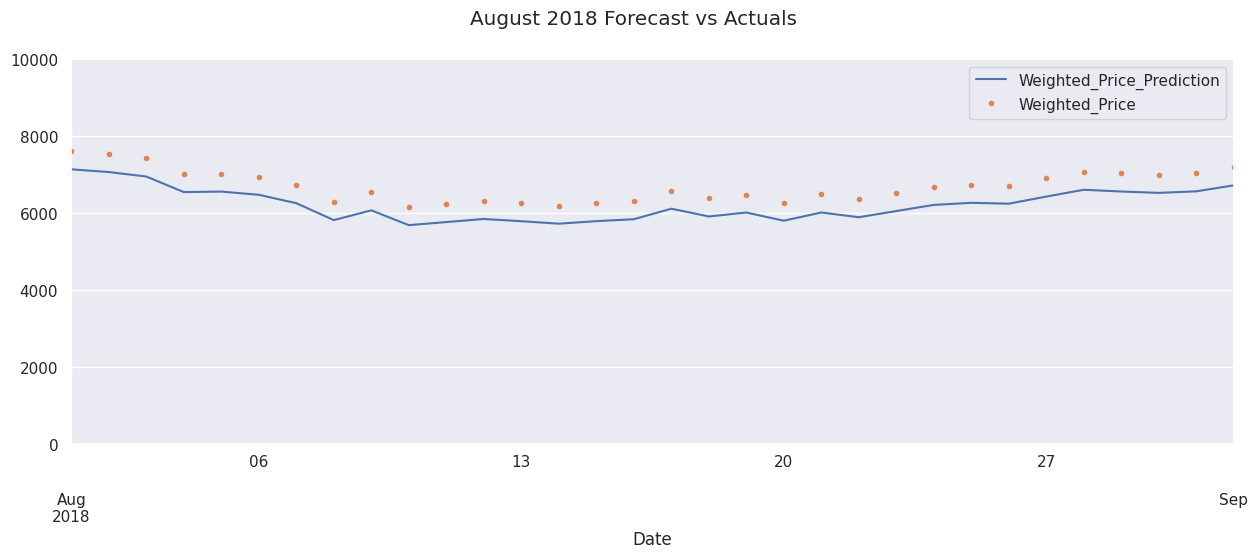

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# Hàm chuyển đổi giá trị chứa 'K', 'M' hoặc '%'
def convert_to_float(value):
    if isinstance(value, str):
        value = value.replace(',', '').replace('%', '')  # Xóa dấu phẩy và dấu %
        if 'K' in value:
            return float(value.replace('K', '')) * 1000
        elif 'M' in value:
            return float(value.replace('M', '')) * 1000000
        elif '%' in value:
            return float(value.replace('%', '')) / 100  # Chuyển đổi phần trăm thành số thực
    try:
        return float(value)
    except ValueError:
        return np.nan  # Tránh lỗi khi gặp giá trị không thể chuyển đổi

# Áp dụng chuyển đổi cho tất cả các cột có dữ liệu dạng chuỗi
data_test = data_test.map(convert_to_float)

# Xóa các dòng chứa NaN để tránh lỗi về kích thước dữ liệu
data_test.dropna(inplace=True)
print(f"Số dòng sau khi xử lý: {len(data_test)}")

# Kiểm tra kích thước dữ liệu ban đầu
print(f"Số lượng mẫu ban đầu: {data_test.shape[0]}")

# Kiểm tra tên cột trong data_test
print("Các cột trong data_test:", data_test.columns)

# Kiểm tra xem cột 'Weighted_Price' có tồn tại không, nếu không đổi thành 'Price'
if 'Weighted_Price' not in data_test.columns and 'Price' in data_test.columns:
    data_test = data_test.rename(columns={'Price': 'Weighted_Price'})

# Chuẩn bị tập dữ liệu kiểm tra (chỉ chọn cột Weighted_Price)
test_set = data_test[['Weighted_Price']].to_numpy()
print(f"Kích thước test_set trước reshape: {test_set.shape}")

test_set = test_set.reshape(len(data_test), 1)
print(f"Kích thước test_set sau reshape: {test_set.shape}")

# Chuẩn hóa dữ liệu đầu vào
inputs = sc.transform(test_set)
inputs = np.reshape(inputs, (test_set.shape[0], 1, 1))  # Định dạng lại cho phù hợp với mô hình
print(f"Kích thước inputs: {inputs.shape}")

# Dự đoán giá Bitcoin
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)  # Chuyển dữ liệu về giá trị ban đầu
print(f"Kích thước predicted_BTC_price: {predicted_BTC_price.shape}")

# Đảm bảo số lượng dòng phù hợp với data_test
if predicted_BTC_price.shape[0] == data_test.shape[0]:
    data_test['Weighted_Price_Prediction'] = predicted_BTC_price
    print("Thêm cột dự đoán thành công!")
else:
    print(f"Lỗi: Số dòng dự đoán ({predicted_BTC_price.shape[0]}) không khớp với tập dữ liệu kiểm tra ({data_test.shape[0]})!")

# Gộp dữ liệu kiểm tra và huấn luyện
data_all = pd.concat([data_test, data_train], sort=False)

# Lưu kết quả dự đoán vào DataFrame chung để so sánh sau này
final_data = data_all.reset_index()
final_data = final_data.rename(columns={'Weighted_Price_Prediction': 'lstm'})
final_data = final_data[['Date', 'Weighted_Price', 'lstm']]

# Vẽ biểu đồ so sánh giá trị thực và giá trị dự đoán
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
data_all[['Weighted_Price_Prediction', 'Weighted_Price']].plot(ax=ax, style=['-', '.'])
ax.set_xbound(lower='08-01-2018', upper='09-01-2018')
ax.set_ylim(0, 10000)
plt.suptitle('August 2018 Forecast vs Actuals')
plt.show()
